In [73]:
import pandas as pd
import numpy as np
from matplotlib import colors, cm, text, pyplot as plt
import matplotlib.patches as patches

In [74]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

In [75]:
import peakutils
from scipy import signal
import math

In [76]:
# define a straight line to exclude the charge-1 cloud
def scan_coords_for_single_charge_region(mz_lower, mz_upper):
    scan_for_mz_lower = -1 * ((1.2 * mz_lower) - 1252)
    scan_for_mz_upper = -1 * ((1.2 * mz_upper) - 1252)
    return (scan_for_mz_lower,scan_for_mz_upper)

In [77]:
MZ_MIN = 748
MZ_MAX = 766

In [78]:
charge_one_scan_max = max(scan_coords_for_single_charge_region(mz_lower=MZ_MIN, mz_upper=MZ_MAX))

In [79]:
charge_one_scan_max

354.4

In [80]:
MZ_MIN_DEBUG, MZ_MAX_DEBUG = (764.4201958278368, 765.9385489808168)
SCAN_MIN_DEBUG, SCAN_MAX_DEBUG = (400, 460)
RT_LOWER_DEBUG, RT_UPPER_DEBUG = (2103.4829066671086, 2110.362298691853)

In [144]:
raw_df = pd.read_pickle('/Users/darylwilding-mcbride/Downloads/YHE211_1-mz-748-766-rt-2000-2200.pkl')
raw_df = raw_df[(raw_df.frame_type == 0) & (raw_df.intensity >= 50) & (raw_df.scan >= charge_one_scan_max)]
# raw_df = raw_df[(raw_df.mz >= MZ_MIN_DEBUG) & (raw_df.mz <= MZ_MAX_DEBUG) & (raw_df.scan >= SCAN_MIN_DEBUG) & (raw_df.scan <= SCAN_MAX_DEBUG) & (raw_df.retention_time_secs >= RT_LOWER_DEBUG) & (raw_df.retention_time_secs <= RT_UPPER_DEBUG)]
raw_df.reset_index(drop=True, inplace=True)

In [145]:
# assign each point a unique identifier
raw_df['point_id'] = raw_df.index

In [146]:
raw_df.head()

,frame_id,frame_type,mz,scan,intensity,retention_time_secs,point_id
0,18187,0,748.002161,765,81,2028.860792,0
1,18987,0,748.002161,627,93,2113.537640,1
2,18987,0,748.002161,648,62,2113.537640,2
3,18972,0,748.002161,657,66,2111.950076,3
4,18987,0,748.002161,675,132,2113.537640,4


#### repeast from here

In [1011]:
# find the most intense point
anchor_point_s = raw_df.loc[raw_df.intensity.idxmax()]
anchor_point_s

frame_id                19557.000000
frame_type                  0.000000
mz                        756.398076
scan                      695.000000
intensity                1828.000000
retention_time_secs      2173.874280
point_id               506390.000000
Name: 506390, dtype: float64

In [1012]:
mz_lower = anchor_point_s.mz - 1.0
mz_upper = anchor_point_s.mz + 7.0
scan_lower = anchor_point_s.scan - 100
scan_upper = anchor_point_s.scan + 100

In [1013]:
candidate_region_df = raw_df[(raw_df.frame_id == anchor_point_s.frame_id) & (raw_df.mz >= mz_lower) & (raw_df.mz <= mz_upper) & (raw_df.scan >= scan_lower) & (raw_df.scan <= scan_upper)].copy()


In [1014]:
MS1_PEAK_DELTA = 0.1

In [1015]:
peak_mz_lower = anchor_point_s.mz-MS1_PEAK_DELTA
peak_mz_upper = anchor_point_s.mz+MS1_PEAK_DELTA

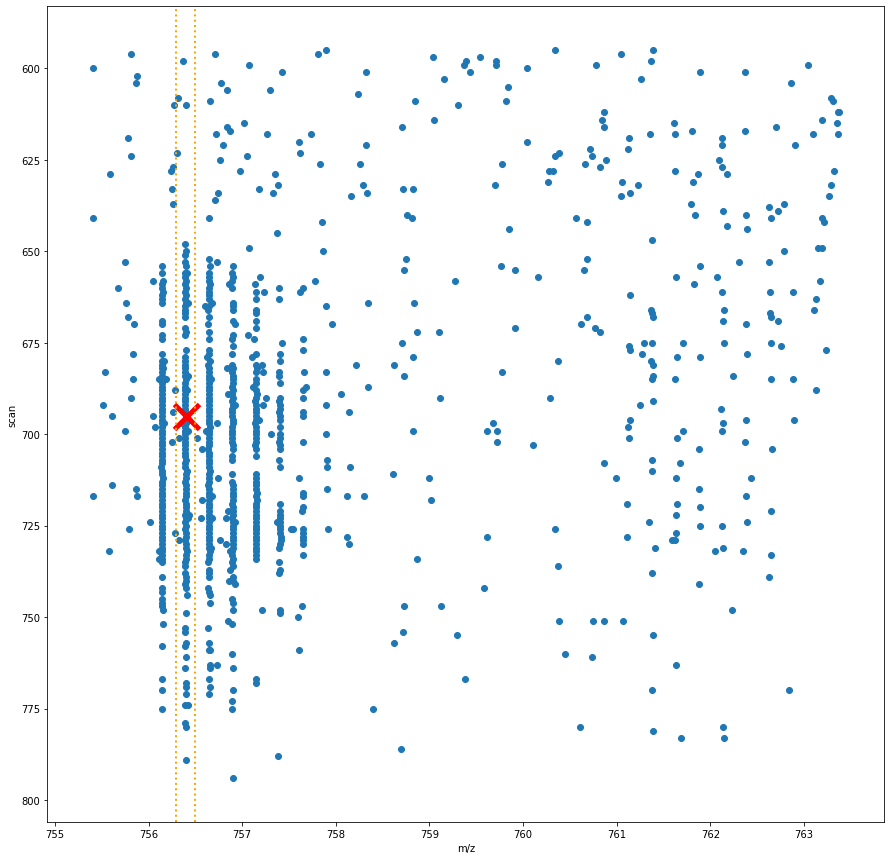

In [1016]:
# plot the cluster assignments
f, ax1 = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)

plt.margins(0.06)

plt.scatter(candidate_region_df.mz, candidate_region_df.scan)
plt.plot(anchor_point_s.mz, anchor_point_s.scan, marker='x', markerfacecolor='none', markeredgecolor='red', linestyle='', markeredgewidth=5, ms=25, label='anchor point')

plt.axvline(x=peak_mz_lower, linestyle=':', color='orange', linewidth=2)
plt.axvline(x=peak_mz_upper, linestyle=':', color='orange', linewidth=2)

plt.xlabel("m/z")
plt.ylabel("scan")
plt.gca().invert_yaxis()
plt.show()

In [1017]:
peak_df = candidate_region_df[(candidate_region_df.mz >= peak_mz_lower) & (candidate_region_df.mz <= peak_mz_upper)]

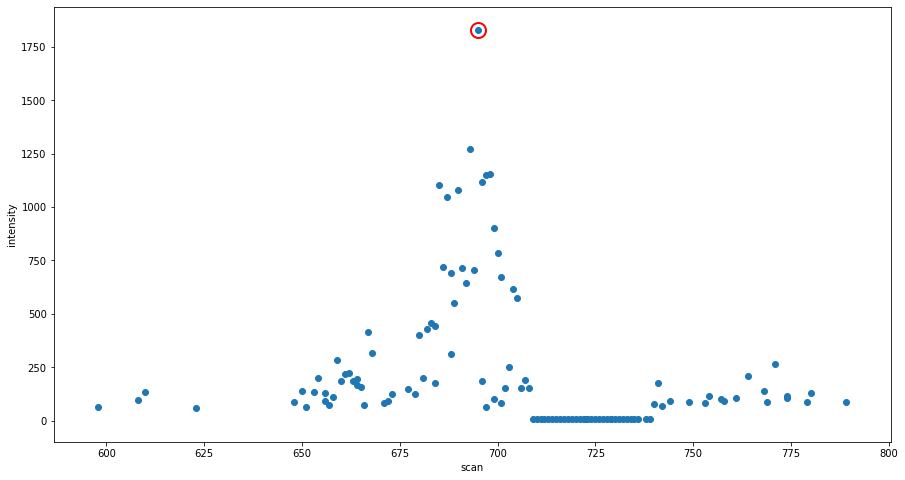

In [1018]:
# plot the cluster assignments
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

plt.scatter(peak_df.scan, peak_df.intensity)
plt.plot(anchor_point_s.scan, anchor_point_s.intensity, marker='o', markerfacecolor='none', markeredgecolor='red', linestyle='', markeredgewidth=2, ms=15, label='anchor point')

plt.xlabel("scan")
plt.ylabel("intensity")
plt.show()

In [1019]:
scan_0_df = peak_df.groupby(['scan'], as_index=False).intensity.sum()
scan_0_df.sort_values(by=['scan'], ascending=True, inplace=True)
# filter the points
scan_0_df['filtered_intensity'] = scan_0_df.intensity  # set the default
window_length = 21
if len(scan_0_df) > window_length:
    try:
        scan_0_df['filtered_intensity'] = signal.savgol_filter(scan_0_df.intensity, window_length=window_length, polyorder=2)
        filtered = True
    except:
        filtered = False
else:
    filtered = False

In [1020]:
filtered

True

In [1021]:
peak_idxs = peakutils.indexes(scan_0_df.filtered_intensity.values, thres=0.05, min_dist=10/2, thres_abs=False)
peak_x_l = scan_0_df.iloc[peak_idxs].scan.to_list()
peaks_df = scan_0_df[scan_0_df.scan.isin(peak_x_l)]

In [1022]:
valley_idxs = peakutils.indexes(-scan_0_df.filtered_intensity.values, thres=0.05, min_dist=10/2, thres_abs=False)
valley_x_l = scan_0_df.iloc[valley_idxs].scan.to_list()
valleys_df = scan_0_df[scan_0_df.scan.isin(valley_x_l)]

In [1023]:
valleys_df

,scan,intensity,filtered_intensity
22,671,81,141.897025
42,695,1828,1063.298137
61,714,10,-25.839490
77,730,10,0.232756


In [1024]:
upper_x = valleys_df[valleys_df.scan > anchor_point_s.scan].scan.min()
if math.isnan(upper_x):
    upper_x = scan_0_df.scan.max()
lower_x = valleys_df[valleys_df.scan < anchor_point_s.scan].scan.max()
if math.isnan(lower_x):
    lower_x = scan_0_df.scan.min()

In [1025]:
scan_0_extract_df = scan_0_df[(scan_0_df.scan >= lower_x) & (scan_0_df.scan <= upper_x)]

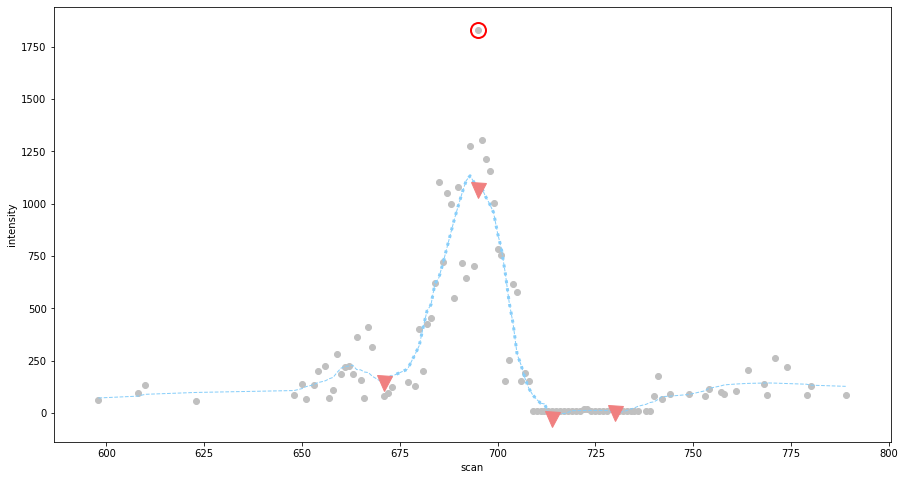

In [1026]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

# plot the flattened points
plt.scatter(scan_0_df.scan, scan_0_df.intensity, c='silver')
# plot the smoothed points
plt.plot(scan_0_df.scan, scan_0_df.filtered_intensity, marker='', color='lightskyblue', linestyle='--', linewidth=1, ms=5, label='smoothed')
plt.plot(scan_0_extract_df.scan, scan_0_extract_df.filtered_intensity, marker='', color='lightskyblue', linestyle=':', linewidth=3, ms=5, label='extracted')

plt.plot(valleys_df.scan, valleys_df.filtered_intensity, marker='v', color='lightcoral', linestyle=None, linewidth=0, ms=15, label='valleys')
plt.plot(anchor_point_s.scan, anchor_point_s.intensity, marker='o', markerfacecolor='none', markeredgecolor='red', linestyle='', markeredgewidth=2, ms=15, label='anchor point')

plt.xlabel("scan")
plt.ylabel("intensity")
plt.show()

#### trim the candidate region to account for the selected peak in mobility

In [1027]:
candidate_region_df = candidate_region_df[(candidate_region_df.scan >= lower_x) & (candidate_region_df.scan <= upper_x)]

#### segment the raw data to reveal the isotopes in the feature

In [1028]:
X = candidate_region_df[['mz','scan']].values

In [1029]:
def custom_metric(r1, r2):
    mz_1 = r1[0]
    scan_1 = r1[1]
    mz_2 = r2[0]
    scan_2 = r2[1]
    if (abs(mz_1 - mz_2) <= 0.1) and (abs(scan_1 - scan_2) <= 2):
        result = 0.5
    else:
        result = 10
    return result;

In [1030]:
# cluster the data
dbscan = DBSCAN(eps=1, min_samples=3, metric=custom_metric)
clusters = dbscan.fit_predict(X)

In [1031]:
candidate_region_df['cluster'] = clusters

In [1032]:
candidate_region_df.sample(n=5)

,frame_id,frame_type,mz,scan,intensity,retention_time_secs,point_id,cluster
486902,19557,0,756.143620,692,912,2173.87428,486902,0
804691,19557,0,761.383683,681,86,2173.87428,804691,13
534401,19557,0,756.898489,692,499,2173.87428,534401,3
534376,19557,0,756.898489,684,144,2173.87428,534376,3
515047,19557,0,756.648262,707,472,2173.87428,515047,1


In [1033]:
number_of_point_clusters = len(candidate_region_df[candidate_region_df.cluster >= 0].cluster.unique())
print('found {} point clusters'.format(number_of_point_clusters))

found 14 point clusters


In [1034]:
colour_map = plt.get_cmap('gist_ncar')
norm = colors.Normalize(vmin=candidate_region_df.cluster.min(), vmax=candidate_region_df.cluster.max(), clip=False)

In [1035]:
# calculate the cluster centroids
centroids_l = []
for group_name,group_df in candidate_region_df.groupby(['cluster'], as_index=False):
    if group_name >= 0:
        mz_centroid = peakutils.centroid(group_df.mz, group_df.intensity)
        scan_centroid = peakutils.centroid(group_df.scan, group_df.intensity)
        centroids_l.append((group_name, mz_centroid, scan_centroid))
centroids_df = pd.DataFrame(centroids_l, columns=['cluster','mz','scan'])

In [1036]:
# determine a colour for each cluster
cluster_colour_l = []
for group_name,group_df in candidate_region_df.groupby(['cluster'], as_index=False):
    c = colour_map(norm(group_name), bytes=False)[:3]
    cluster_colour_l.append((group_name, c))
cluster_colour_df = pd.DataFrame(cluster_colour_l, columns=['cluster','colour'])

In [1037]:
# give each point a colour
candidate_region_df = pd.merge(candidate_region_df, cluster_colour_df, how='left', left_on=['cluster'], right_on=['cluster'])


In [1038]:
candidate_region_df.sample(n=3)

,frame_id,frame_type,mz,scan,intensity,retention_time_secs,point_id,cluster,colour
239,19557,0,757.399067,703,111,2173.87428,564340,9,"(1.0, 0.14918899559823937, 0.0)"
178,19557,0,756.898489,703,131,2173.87428,534424,3,"(0.0, 0.986936604088444, 0.368548620127168)"
314,19557,0,762.136833,697,60,2173.87428,852206,-1,"(0.0, 0.0, 0.502)"


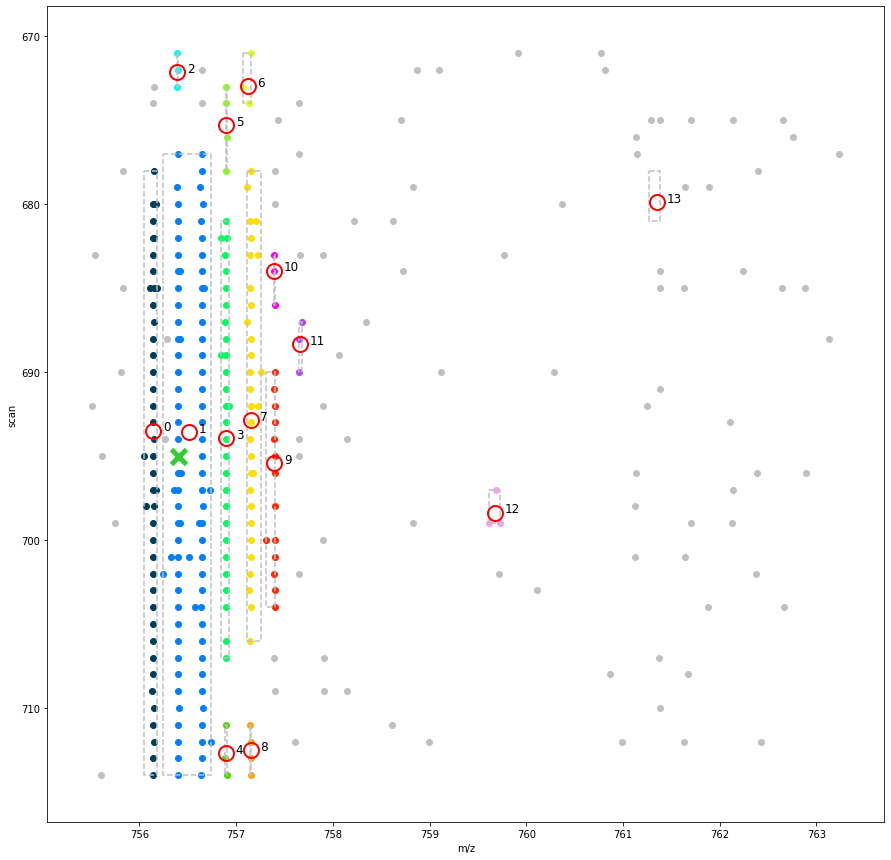

In [1039]:
# plot the cluster assignments
f, ax1 = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)

plt.margins(0.06)

# plot the unassigned points
df = candidate_region_df[(candidate_region_df.cluster == -1)]
plt.scatter(df.mz, df.scan, c='silver')

df = candidate_region_df[(candidate_region_df.cluster >= 0)]
for group_name,group_df in df.groupby(['cluster'], as_index=False):
    # the raw points
    plt.scatter(group_df.mz, group_df.scan, c=np.array([group_df.iloc[0].colour]))
    # the cluster centroid
    centroid_s = centroids_df[(centroids_df.cluster == group_name)].iloc[0]
    plt.plot(centroid_s.mz, centroid_s.scan, marker='o', markerfacecolor='none', markeredgecolor='red', linestyle='', markeredgewidth=2, ms=15)
    ax1.text(centroid_s.mz+0.1, centroid_s.scan, group_name, fontsize=12)
    # draw the cluster rectangle
    top_left = (group_df.mz.min(),group_df.scan.min())
    width = group_df.mz.max() - group_df.mz.min()
    height = group_df.scan.max() - group_df.scan.min()
    cluster_rect = patches.Rectangle(top_left,width,height,linewidth=1.5,linestyle='--',edgecolor='silver',facecolor='none')
    ax1.add_patch(cluster_rect)

# the anchor point for this candidate region
plt.plot(anchor_point_s.mz, anchor_point_s.scan, marker='x', markerfacecolor='none', markeredgecolor='limegreen', linestyle='', markeredgewidth=5, ms=15, label='anchor point')

plt.xlabel("m/z")
plt.ylabel("scan")
plt.gca().invert_yaxis()
plt.show()

In [1040]:
centroids_df

,cluster,mz,scan
0,0,756.143090,693.484263
1,1,756.509169,693.564140
2,2,756.391729,672.143813
3,3,756.895243,693.950686
4,4,756.895612,712.666667
5,5,756.898789,675.307246
6,6,757.118692,672.976636
7,7,757.151582,692.841798
8,8,757.148757,712.500000
9,9,757.395718,695.409384


In [1041]:
def isotope_metric(r1, r2):
    mz_1 = r1[0]
    scan_1 = r1[1]
    mz_2 = r2[0]
    scan_2 = r2[1]
    if (abs(mz_1 - mz_2) <= 1.0) and (abs(mz_1 - mz_2) > 0.1) and (abs(scan_1 - scan_2) <= 5):
        result = 0.5
    else:
        result = 10
    # print('r1={}, r2={}, result={}'.format(r1,r2,result))
    return result;

In [1042]:
X = centroids_df[['mz','scan']].values

In [1043]:
# cluster the data
dbscan = DBSCAN(eps=1, min_samples=1, metric=isotope_metric)
clusters = dbscan.fit_predict(X)
centroids_df['isotope_cluster'] = clusters

In [1044]:
number_of_isotope_clusters = len(centroids_df[centroids_df.isotope_cluster >= 0].isotope_cluster.unique())
print('found {} isotope clusters'.format(number_of_isotope_clusters))

found 3 isotope clusters


In [1045]:
candidate_region_df = pd.merge(candidate_region_df, centroids_df[['cluster','isotope_cluster']], how='left', left_on=['cluster'], right_on=['cluster'])


In [1046]:
candidate_region_df.fillna(value=-1, inplace=True)
candidate_region_df.isotope_cluster = candidate_region_df.isotope_cluster.astype(int)

In [1047]:
candidate_region_df.sample(n=3)

,frame_id,frame_type,mz,scan,intensity,retention_time_secs,point_id,cluster,colour,isotope_cluster
105,19557,0,756.622379,679,70,2173.87428,513373,1,"(0.0, 0.4981591003460206, 1.0)",0
250,19557,0,757.649418,694,122,2173.87428,573325,-1,"(0.0, 0.0, 0.502)",-1
41,19557,0,756.147932,673,102,2173.87428,487344,-1,"(0.0, 0.0, 0.502)",-1


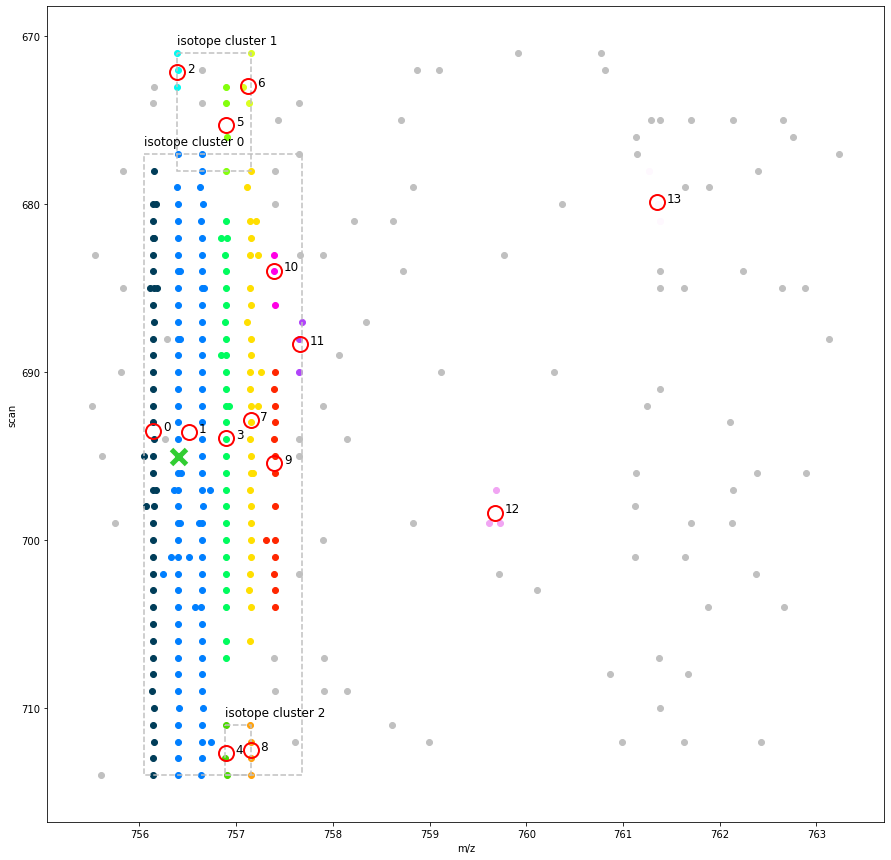

In [1048]:
# plot the cluster assignments
f, ax1 = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)

plt.margins(0.06)

# plot the unassigned points
df = candidate_region_df[(candidate_region_df.cluster == -1)]
plt.scatter(df.mz, df.scan, c='silver')

df = candidate_region_df[(candidate_region_df.cluster >= 0)]
for group_name,group_df in df.groupby(['cluster'], as_index=False):
    # the raw points
    plt.scatter(group_df.mz, group_df.scan, c=np.array([group_df.iloc[0].colour]))
    # the cluster centroid
    centroid_s = centroids_df[(centroids_df.cluster == group_name)].iloc[0]
    plt.plot(centroid_s.mz, centroid_s.scan, marker='o', markerfacecolor='none', markeredgecolor='red', linestyle='', markeredgewidth=2, ms=15)
    ax1.text(centroid_s.mz+0.1, centroid_s.scan, group_name, fontsize=12)

df = candidate_region_df[(candidate_region_df.isotope_cluster >= 0)]
for group_name,group_df in df.groupby(['isotope_cluster'], as_index=False):
    # draw the cluster rectangle
    top_left = (group_df.mz.min(),group_df.scan.min())
    width = group_df.mz.max() - group_df.mz.min()
    height = group_df.scan.max() - group_df.scan.min()
    cluster_rect = patches.Rectangle(top_left,width,height,linewidth=1.5,linestyle='--',edgecolor='silver',facecolor='none')
    ax1.add_patch(cluster_rect)
    ax1.text(top_left[0], top_left[1]-0.5, 'isotope cluster {}'.format(int(group_name)), fontsize=12)

# the anchor point for this candidate region
plt.plot(anchor_point_s.mz, anchor_point_s.scan, marker='x', markerfacecolor='none', markeredgecolor='limegreen', linestyle='', markeredgewidth=5, ms=15, label='anchor point')

plot_xlim = ax1.get_xlim()
plot_ylim = ax1.get_ylim()

plt.xlabel("m/z")
plt.ylabel("scan")
plt.gca().invert_yaxis()
plt.show()

#### we now have the 2D extent of the feature - take that extent through time and see if we can cluster the centroids in time

In [1049]:
# which cluster contains the anchor point?
anchor_point_s = candidate_region_df[(candidate_region_df.point_id == anchor_point_s.point_id)].iloc[0]


In [1050]:
anchor_point_s

frame_id                                        19557
frame_type                                          0
mz                                            756.398
scan                                              695
intensity                                        1828
retention_time_secs                           2173.87
point_id                                       506390
cluster                                             1
colour                 (0.0, 0.4981591003460206, 1.0)
isotope_cluster                                     0
Name: 90, dtype: object

In [1051]:
# get the extent of the isotope cluster in m/z and mobility
points_in_cluster_df = candidate_region_df[(candidate_region_df.isotope_cluster == anchor_point_s.isotope_cluster)]
mz_lower = points_in_cluster_df.mz.min()
mz_upper = points_in_cluster_df.mz.max()
scan_lower = points_in_cluster_df.scan.min()
scan_upper = points_in_cluster_df.scan.max()

In [1052]:
RT_BASE_PEAK_WIDTH = 10

In [1053]:
# get the left-most peak in the isotope cluster
monoisotopic_cluster_s = centroids_df.loc[centroids_df[(centroids_df.isotope_cluster == anchor_point_s.isotope_cluster)].mz.idxmin()]


In [1054]:
mono_raw_points_df = raw_df[(raw_df.mz >= monoisotopic_cluster_s.mz-MS1_PEAK_DELTA) & (raw_df.mz <= monoisotopic_cluster_s.mz+MS1_PEAK_DELTA) & (raw_df.scan >= scan_lower) & (raw_df.scan <= scan_upper) & (raw_df.retention_time_secs >= anchor_point_s.retention_time_secs-RT_BASE_PEAK_WIDTH) & (raw_df.retention_time_secs <= anchor_point_s.retention_time_secs+RT_BASE_PEAK_WIDTH)]
rt_0_df = mono_raw_points_df.groupby(['frame_id','retention_time_secs'], as_index=False).intensity.sum()
rt_0_df.sort_values(by=['retention_time_secs'], ascending=True, inplace=True)
# filter the points
rt_0_df['filtered_intensity'] = rt_0_df.intensity  # set the default
window_length = 11
if len(rt_0_df) > window_length:
    try:
        rt_0_df['filtered_intensity'] = signal.savgol_filter(rt_0_df.intensity, window_length=window_length, polyorder=3)
        filtered = True
    except:
        filtered = False
else:
    filtered = False

In [1055]:
filtered

True

In [1056]:
peak_idxs = peakutils.indexes(rt_0_df.filtered_intensity.values, thres=0.05, min_dist=10/2, thres_abs=False)
peak_x_l = rt_0_df.iloc[peak_idxs].retention_time_secs.to_list()
peaks_df = rt_0_df[rt_0_df.retention_time_secs.isin(peak_x_l)]

In [1057]:
valley_idxs = peakutils.indexes(-rt_0_df.filtered_intensity.values, thres=0.05, min_dist=10/8, thres_abs=False)
valley_x_l = rt_0_df.iloc[valley_idxs].retention_time_secs.to_list()
valleys_df = rt_0_df[rt_0_df.retention_time_secs.isin(valley_x_l)]

In [1058]:
valleys_df

,frame_id,retention_time_secs,intensity,filtered_intensity
8,19507,2168.581009,217,120.132867
28,19607,2179.164516,286,43.424242
30,19617,2180.222723,368,155.421911


In [1059]:
upper_x = valleys_df[valleys_df.retention_time_secs > anchor_point_s.retention_time_secs].retention_time_secs.min()
if math.isnan(upper_x):
    upper_x = rt_0_df.retention_time_secs.max()
lower_x = valleys_df[valleys_df.retention_time_secs < anchor_point_s.retention_time_secs].retention_time_secs.max()
if math.isnan(lower_x):
    lower_x = rt_0_df.retention_time_secs.min()

In [1060]:
rt_lower = lower_x
rt_upper = upper_x

In [1061]:
rt_0_extract_df = rt_0_df[(rt_0_df.retention_time_secs >= lower_x) & (rt_0_df.retention_time_secs <= upper_x)]

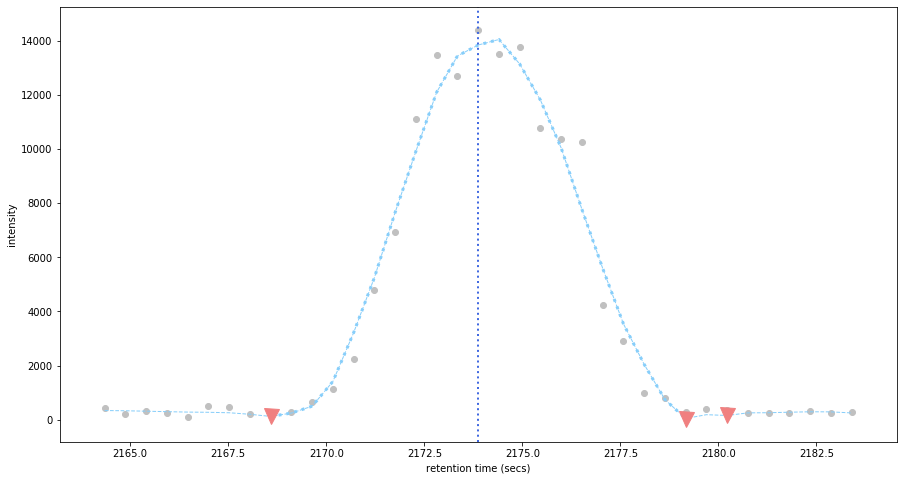

In [1062]:
# plot the cluster assignments
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

# plot the flattened points
plt.scatter(rt_0_df.retention_time_secs, rt_0_df.intensity, c='silver')
# plot the smoothed points
plt.plot(rt_0_df.retention_time_secs, rt_0_df.filtered_intensity, marker='', color='lightskyblue', linestyle='--', linewidth=1, ms=5, label='smoothed')
plt.plot(rt_0_extract_df.retention_time_secs, rt_0_extract_df.filtered_intensity, marker='', color='lightskyblue', linestyle=':', linewidth=3, ms=5, label='extracted')

plt.plot(valleys_df.retention_time_secs, valleys_df.filtered_intensity, marker='v', color='lightcoral', linestyle=None, linewidth=0, ms=15, label='valleys')
plt.axvline(x=anchor_point_s.retention_time_secs, linestyle=':', color='royalblue', linewidth=2, label='anchor point')

plt.xlabel("retention time (secs)")
plt.ylabel("intensity")
plt.show()

In [1063]:
# set the intensity to zero for all points in the candidate region points
raw_df.loc[(raw_df.retention_time_secs >= rt_lower) & (raw_df.retention_time_secs <= rt_upper) & (raw_df.mz >= mz_lower) & (raw_df.mz <= mz_upper) & (raw_df.scan >= scan_lower) & (raw_df.scan <= scan_upper), 'intensity'] = 10

In [1064]:
len(raw_df[(raw_df.intensity == 10)])

38126

In [1065]:
mz_lower, mz_upper

(756.0487483544697, 757.6839521562737)

In [1066]:
scan_lower, scan_upper

(677, 714)

In [1067]:
rt_lower, rt_upper

(2168.5810089657934, 2179.164515829139)